# Main Script: MCDM Asteroid Selection

## Import Packages

In [1]:
import pandas as pd
import asteroid_db
import asteroid_orbital
import asteroid_products
import asteroid_decision

## User requirements

Here the user must select:

- The H range of the asteroids analyzed (considering a range of albedos between 0.06 characteristic for C-type asteroids and 0.16 for S-type asteroids) - For asteroids 4-9m H[29-30] is recommended, for asteroids 100-350m H[21-22.5]. See https://nssdc.gsfc.nasa.gov/planetary/text/asteroids.txt

- Range of dates of natural approach (see next section) of the asteroid analyzed to the Earth and a distance reference for parabolic limit computation (see next section) , to enable its capture.

- Reference thresholds of orbit similaty metric (see next section) and distance to a possible back up asteroid

- Additional filter in case there are many candidates only consider those that have any of this info available: taxonomy or presence of satellites or spin period.

In [2]:
H_min=21 #Min absolute magnitude of asteroid analysed (29 for small / 21 medium)
H_max=22.5 #Max absolute magnitude of asteroid analysed (30 for small / 22.5 medium)
date_app_min='2030-01-01' #Min close-approach date
date_app_max='2035-01-01' #Max close-approach date
dist_app=0.2 #Close approach definition threshold [AU]
dist_ast_thres=0.2 #For back-up asteroid target distance threshold [AU]
orbit_similarity_thres=0.2 #For back-up asteroid target similarity metric threshold [AU]
filter=1 #If=0 raw asteroid database; if=1 only PHA with spin OR taxonomy OR with secondary body are considered/
         # =0 recomended for small asteroids =1 for asteroid with D>100m

## Asteroid databases loading

Data extraction through APIS:

- Asteroid data: https://ssd.jpl.nasa.gov/tools/sbdb_query.html

- Earth approach data of the period analysed https://cneos.jpl.nasa.gov/ca/

- NHATS data: https://cneos.jpl.nasa.gov/nhats/

- Geometric model data from DAMIT: https://astro.troja.mff.cuni.cz/projects/damit/

Additional information is available in the functions and modules.

In [3]:
asteroid, asteroid_app, asteroid_NHATS, asteroid_geometry, input_file = \
                             asteroid_db.asteroid_load(H_min,H_max,date_app_min,date_app_max,dist_app)
asteroid_removed= pd.DataFrame(columns=asteroid.columns) #Initialization; no candidates excluded atm

## Compute orbital parameters and solutions

Main loop:
- Iterate through all asteroids that meet the parameters set by the user eliminating from the list those that do not have a natural approach to Earth in the period of interest and additional filters (if enabled). Considering only Earth close approachers asteroid is described in https://ieeexplore.ieee.org/document/6836358

- Estimate the delta_v of the capture as described at https://www.researchgate.net/publication236163825_Near-Earth_asteroid_resource_accessibility_and_future_capture_mission_opportunities

- Compute the synodic period

- Include the computed data

- Taking into account orbit similaty and distance thresholds, compute the number of potential backup asteroids (within the natural close approachers list) in case it becomes necessary to redirect the mission once in flight. Additional info about similarity metric computations can be found in https://www.sciencedirect.com/science/article/pii/S0273117724004307

Additional information is available in the functions and modules.

In [4]:
for n_ast in range(len(asteroid)-1,-1,-1): #Iterate from the last element to enable delete asteroid

    # Remove NO close approachers and check if additional info is available
    cont,approaches, approach_date, is_NHATS,is_geometry, asteroid_removed=asteroid_db.asteroid_filtering(filter,n_ast,asteroid, asteroid_removed,asteroid_app,asteroid_NHATS, asteroid_geometry)
    if cont==0: continue #Remove asteroid as candidate and continue
    
    # Compute accesibility via delta_v [m/s]]
    delta_v_tot=asteroid_orbital.asteroid_accessibility(n_ast, asteroid)
    
    # Compute synodic period [years]
    period_sin=asteroid_orbital.asteroid_period(n_ast,asteroid)

    # Update info
    asteroid.loc[n_ast, ['delta_v_tot', 'period_sin', 'approaches','date_approach', 'is_NHATS', 'is_geometry']] = [
    delta_v_tot, period_sin, approaches,approach_date, is_NHATS, is_geometry]

    
asteroid.reset_index(drop=True, inplace=True) # Remove empty rows
for n_ast in range(len(asteroid)): 

    # Compute number of posible backup targets within 'approachers' list
    n_backup=asteroid_orbital.asteroid_similarity(n_ast,asteroid,asteroid,orbit_similarity_thres,dist_ast_thres)

    # Include results in the available info
    asteroid.loc[n_ast, ['n_backup']] = [n_backup]


## Generate solution csv, simplified table and plots

A simplified table including: ID, accesibility estimation, popential backup asteroids, orbit uncertainty (condition code), synodic period, spin rate and additional information (when available) is shown and saved in txt. This table could potentionally be used as analysis abstract to decision makers.

Accesibility plots are shown and saved

Additional information is available in the functions and modules.

+--------------------------+--------------------+----------------------------+-------------------+--------------------+-----------------+---------------------------------------------------------------------+
|         Asteroid         | Accesibility [m/s] | Potential backup asteroids | Orbit Uncertainty | Synodic Period [y] | Spin Rate [rpm] |                           Additional Info                           |
+--------------------------+--------------------+----------------------------+-------------------+--------------------+-----------------+---------------------------------------------------------------------+
| 85585 Mjolnir (1998 FG2) |      2755.34       |            2.0             |         0         |        3.09        |      0.0014     |               Included in NHATS database, PHA asteroid              |
|     265482 (2005 EE)     |      3104.53       |            4.0             |         0         |        6.02        |      0.0063     |                             PH

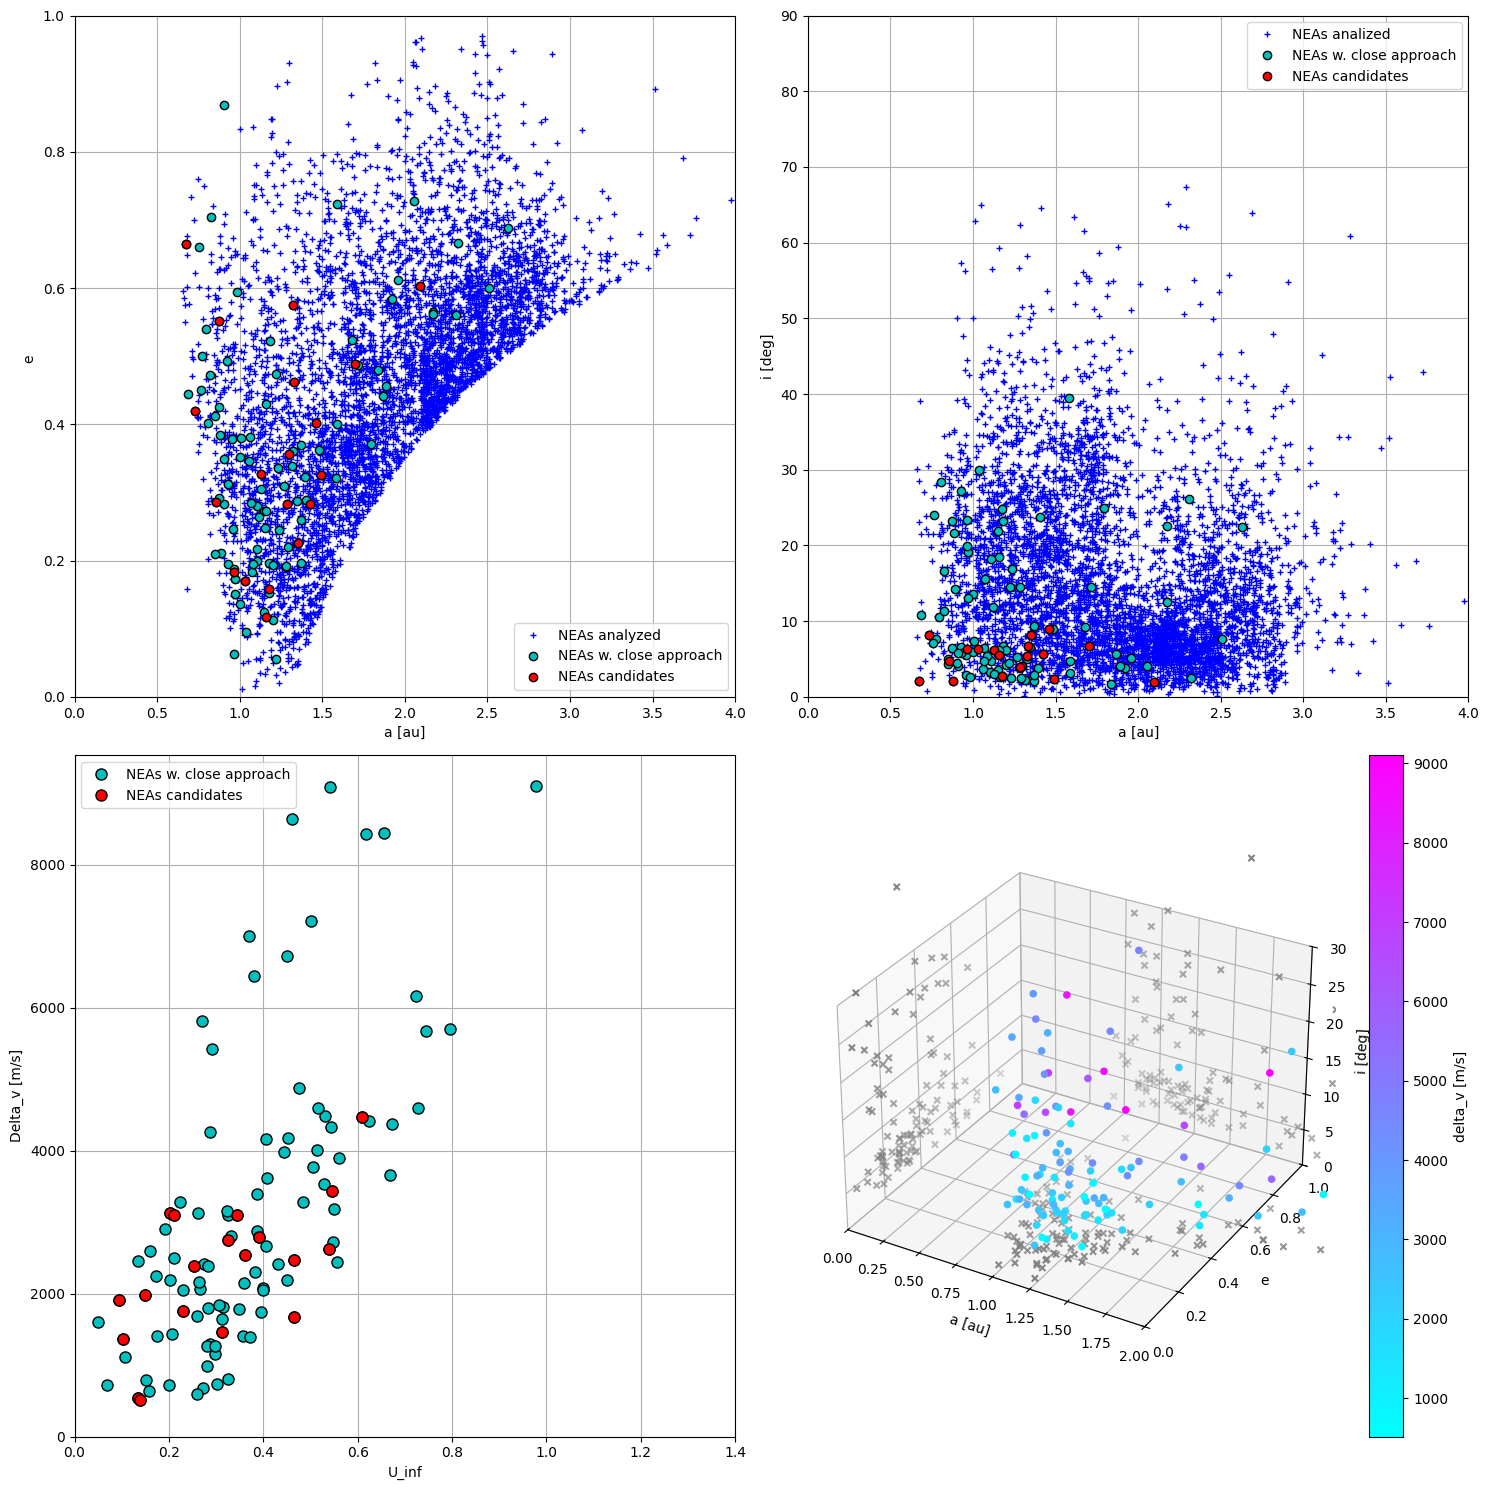

In [5]:
asteroid_products.asteroid_out(H_min,H_max,date_app_min,date_app_max,asteroid,asteroid_removed)     

## MCDM Problem: 

------- WIP -------

Multicriteria Decision Making: Decision table generation, weight calculation, ranking. 

Additional information available in the functions and modules.

In [6]:
# WIP
decision_table=[[float(asteroid.loc[n_ast,'delta_v_tot']), float(asteroid.loc[n_ast,'condition_code']), float(asteroid.loc[n_ast,'period_sin'])] for n_ast in range(len(asteroid))]
criterion_type= ['min','min','min'] #Select the kind of criteria for all criteria


weights=asteroid_decision.weights_merec(decision_table,criterion_type) #### Nelson remember, be careful when any assessment = 0 !!!!!!

# print(decision_table) Example
print(weights)

[nan nan nan]


c:\Users\Administrador\OneDrive - Universidad Politécnica de Cartagena\Doctorado NRL\10 Scripts\.venv\Lib\site-packages\pyDecision\algorithm\merec.py:22: RuntimeWarning: divide by zero encountered in log
  S = np.log(1 + (1/X.shape[1] * np.sum(np.abs(np.log(X)), axis = 1)))
c:\Users\Administrador\OneDrive - Universidad Politécnica de Cartagena\Doctorado NRL\10 Scripts\.venv\Lib\site-packages\pyDecision\algorithm\merec.py:26: RuntimeWarning: divide by zero encountered in log
  R[:, j] = np.log(1 + (1/X.shape[1] * np.sum(np.abs(np.log(Z)), axis = 1)))
c:\Users\Administrador\OneDrive - Universidad Politécnica de Cartagena\Doctorado NRL\10 Scripts\.venv\Lib\site-packages\pyDecision\algorithm\merec.py:27: RuntimeWarning: invalid value encountered in subtract
  E = np.sum(np.abs(R.T - S), axis = 1)
